<a href="https://colab.research.google.com/github/eugeneberta/Exercice_tech/blob/main/Bilberry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bilberry AI Engineer Internship
## Technical Review
### Eugène Berta

This is my work for the technical exercie you asked me to complete.
This notebook is separated into two main parts :
- In the first part I work on the data you provided to create an augmented dataset.
- In the second part I use this new dataset to train a two class classifier.

# Data augmentation


I created a git repository to store the dataset you sent me, the first step is to clone this repo :

In [1]:
!git clone https://github.com/eugeneberta/Exercice_tech.git

Cloning into 'Exercice_tech'...
remote: Enumerating objects: 112, done.
remote: Counting objects: 100% (112/112), done.
remote: Compressing objects: 100% (109/109), done.
remote: Total 112 (delta 2), reused 4 (delta 1), pack-reused 0
Receiving objects: 100% (112/112), 1.28 MiB | 9.87 MiB/s, done.
Resolving deltas: 100% (2/2), done.


Necessary imports for Data augmentation and image classification :

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import save_img
from matplotlib import pyplot
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.autograd import Variable
import os

Creating a folder for my augmented dataset :

In [3]:
!mkdir "Exercice_tech/augmented_data/"
!mkdir "Exercice_tech/augmented_data/road/"
!mkdir "Exercice_tech/augmented_data/field/"

The dataset you provided me with is very clean, all pictures are relevant and I don't need to remove any. Moreover, there are 45 pictures for each class, the dataset is well balanced. For these reasons, I will augment the dataset by applying the same transformations for the images from both classes, and it will result in a balanced dataset.

I can apply the same transformations to images from both classes as the subject are similar enough : we will see that a field and a road have pretty much the same visual caracteristics and the logic we can apply to augment field images is also applicable to road images. That's why we will use the same approach for both classes.

The last thing we notice about the dataset is that all images don't have the same size. This is something we will need to deal with before training our model, but for the augmentation part, I will keep it this way, I don't want to reduce the image quality before applying transformations (shifts / rotations) because it will result in a very poor quality whereas applying transformations first and then remapping the images to the desired size is a better way to process.

The first thing I will do is to save each image of the original dataset in the augmented dataset.
I also add an horizontally flipped version of each image to the augmented dataset.
Horizontal flip is a transformation that suits very well our problem as in most problems concerning vision, the horizontal flip of a field/road is still a field/road and can be used to populate our dataset.

In [4]:
# Field directory :
directory = 'Exercice_tech/data/field/'
for filename in os.listdir(directory):
  image = cv2.imread(directory+filename)
  flipped_image= cv2.flip(image, 1)
  # Write the original image and the horizontal flip to the augmented dataset :
  cv2.imwrite("Exercice_tech/augmented_data/field/"+filename,image)
  cv2.imwrite("Exercice_tech/augmented_data/field/"+"flip_"+filename,flipped_image)

# Road directory :
directory = 'Exercice_tech/data/road/'
for filename in os.listdir(directory):
  image = cv2.imread(directory+filename)
  flipped_image= cv2.flip(image, 1)
  # Write the original image and the horizontal flip to the augmented dataset :
  cv2.imwrite("Exercice_tech/augmented_data/road/"+filename,image)
  cv2.imwrite("Exercice_tech/augmented_data/road/"+"flip_"+filename,flipped_image)

We now have 90 images for each class in our augmented dataset.
As I said before, most images in the original dataset were very clean and taken in an ideal framework, for example, the luminosity was always good.
This corresponds to a bias in our dataset, we need to be able to classify images taken at nightime or in very bright context, for this reason, I decided to populate our dataset with images of various luminosity.

For each image in the augmented dataset, we create 3 new images, identical to the original one, with a randomly picked level of luminosity, between 0.2 and 1.8 times the original brigthness.
This interval is wide enough so that we will have very dark and bright images in the dataset, which will make our model stronger, and it is centered on 1, so that on average, the brightness of the whole dataset doesn't change too much, which would introduce a new unwanted bias.

In [5]:
# Field directory :
directory = 'Exercice_tech/augmented_data/field/'
for filename in os.listdir(directory):
  img = load_img(directory+filename)
  data = img_to_array(img)
  samples = expand_dims(data, 0)
  # Image generator with a brightness range between [0.2, 1.8]
  datagen = ImageDataGenerator(brightness_range=[0.2,1.8])
  iterator = datagen.flow(samples, batch_size=1)
  for i in range(3):
    batch = iterator.next()
    image = batch[0].astype('uint8')
    # Save images to the augmented dataset.
    save_img("Exercice_tech/augmented_data/field/"+filename.split(".")[0]+"_luminosity_sample"+str(i)+".jpg",image)

# Road directory :
directory = 'Exercice_tech/augmented_data/road/'
for filename in os.listdir(directory):
  img = load_img(directory+filename)
  data = img_to_array(img)
  samples = expand_dims(data, 0)
  # Image generator with a brightness range between [0.2, 1.8]
  datagen = ImageDataGenerator(brightness_range=[0.2,1.8])
  iterator = datagen.flow(samples, batch_size=1)
  for i in range(3):
    batch = iterator.next()
    image = batch[0].astype('uint8')
    # Save images to the augmented dataset.
    save_img("Exercice_tech/augmented_data/road/"+filename.split(".")[0]+"_luminosity_sample"+str(i)+".jpg",image)

So far, we have gotten from a very simple and clean dataset (45 images / class), to a wider and less biased one (360 images / class, wide range of luminosity).

However, all our images are issued from our original dataset and they are all "ideal" in the sense that the subject is often in the middle of the picture, and the orientation is always the same.

We want to be able to classify a wide range of images, not necessarily taken in a perfect way. There are a lot of application where we can imagine that the input to our model will not consist in well taken photographs. For example in the case of Bilberry, a camera set up on a spreader will not only take well oriented images of the field, and we still need to be able to recognize that this is a field and not a road.

Moreover, using random shifts and zooms permits to generate a lot of new data, different from the original one, that will make our model stronger and less sensible to the quality of the original image.

This is why, for each image we currently have in our augmented dataset,we generated 4 new images with randoms shifts, rotations and zooms.

- We set the rotation range to [-90°; +90°] so that we don't end up with images upside-down (we assume that a proper picture is taken in the right sens, eventually with a rotation up to 90° and no more).

- We set the height and width shift range to [-20%; +20%] so that the images can be shifted, but not too much and we still can identify a field/road.

- We set the zoom range to [0.5; 1.0] so that the images are always zoomed in (zoom out would mean a big black surrounding of the image, it doesn't enrich the dataset), but not too much, so that the quality is still good enough.

For each image in the original dataset, we create 4 new images so that we populate our dataset with a lot of "original" and "unbiased" images with shifts and rotations.

In [6]:
# Field directory :
directory = 'Exercice_tech/augmented_data/field/'
for filename in os.listdir(directory):
  img = load_img(directory+filename)
  data = img_to_array(img)
  samples = expand_dims(data, 0)
  # Image generator with appropriate transformations and ranges
  datagen = ImageDataGenerator(width_shift_range=0.2, height_shift_range=0.2, rotation_range=90, zoom_range=[0.5,1.0])
  iterator = datagen.flow(samples, batch_size=1)
  for i in range(4):
    batch = iterator.next()
    image = batch[0].astype('uint8')
    # Save images to the augmented dataset.
    save_img("Exercice_tech/augmented_data/field/"+filename.split(".")[0]+"_random_transfo"+str(i)+".jpg",image)

# Road directory :
directory = 'Exercice_tech/augmented_data/road/'
for filename in os.listdir(directory):
  img = load_img(directory+filename)
  data = img_to_array(img)
  samples = expand_dims(data, 0)
  # Image generator with appropriate transformations and ranges
  datagen = ImageDataGenerator(width_shift_range=0.2, height_shift_range=0.2, rotation_range=90, zoom_range=[0.5,1.0])
  iterator = datagen.flow(samples, batch_size=1)
  for i in range(4):
    batch = iterator.next()
    image = batch[0].astype('uint8')
    # Save images to the augmented dataset.
    save_img("Exercice_tech/augmented_data/road/"+filename.split(".")[0]+"_random_transfo"+str(i)+".jpg",image)

In [7]:
field_size = len([name for name in os.listdir('Exercice_tech/augmented_data/field')])
road_size = len([name for name in os.listdir('Exercice_tech/augmented_data/road')])

print("Augmented field dataset size : "+str(field_size))
print("Augmented road dataset size : "+str(road_size))

Augmented field dataset size : 1800
Augmented road dataset size : 1800


To recap this first part, we started with a dataset of 90 images and we now have 3600 images available, exactly the same number for fields and roads, we have a good basis to train a deep neural network.

The following cells randomly pick 5 images from the augmented dataset and display them, it illustrates the different transformations we applied to the data :

In [8]:
def get_random_images(num):
    data = datasets.ImageFolder(data_dir, transform=test_transforms)
    classes = data.classes
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, 
                   sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = dataiter.next()
    return images, labels

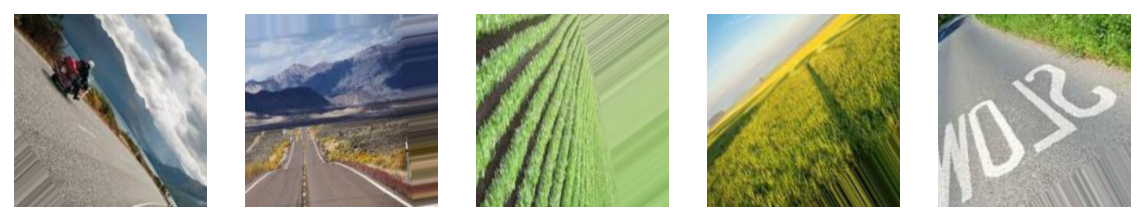

In [11]:
data_dir = 'Exercice_tech/augmented_data/'
test_transforms = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])

to_pil = transforms.ToPILImage()
images, labels = get_random_images(5)
fig=plt.figure(figsize=(10,10))
for ii in range(len(images)):
    image = to_pil(images[ii])
    sub = fig.add_subplot(1, len(images), ii+1)
    plt.axis('off')
    plt.imshow(image)
plt.show()

# Image Classifier

For this second part, I decided to use a pretrained ResNet50 architecture and to retrain the last layers using my augmented datasset.
For this part, I used code snippets from : https://towardsdatascience.com/how-to-train-an-image-classifier-in-pytorch-and-use-it-to-perform-basic-inference-on-single-images-99465a1e9bf5

Please note that to train the network in a reasonable time, you must change the runtime accelerator to GPU in the runtime settings of this notebook, use the next cell to make sure that you use a GPU.

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")
print(device)

cuda


Creating my training set and validation set (80% / 20%) :

In [13]:
data_dir = 'Exercice_tech/augmented_data/'

def load_split_train_test(datadir, valid_size = .2):
    
    train_transforms = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])
    test_transforms = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])
    
    train_data = datasets.ImageFolder(datadir, transform=train_transforms)
    test_data = datasets.ImageFolder(datadir, transform=test_transforms)
    
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)
    
    from torch.utils.data.sampler import SubsetRandomSampler
    train_idx, test_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    trainloader = torch.utils.data.DataLoader(train_data, sampler=train_sampler, batch_size=50)
    testloader = torch.utils.data.DataLoader(test_data, sampler=test_sampler, batch_size=50)

    return trainloader, testloader

trainloader, testloader = load_split_train_test(data_dir, .2)
print(trainloader.dataset.classes)

['field', 'road']


We download our model from pytorch :

In [14]:
model = models.resnet50(pretrained=True)
print(model)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1,

We fix the parameters for the features learning part of the model and we add a new FC neural net on top of it, we are going to train these new layers with our augmented dataset :

In [15]:
for param in model.parameters():
    param.requires_grad = False
    
model.fc = nn.Sequential(nn.Linear(2048, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 10),
                                 nn.LogSoftmax(dim=1))
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Training our model, we go through the dataset twice (epochs = 2), I tried different configurations and observed that more epochs results in overfitting :

In [16]:
epochs = 2
steps = 0
running_loss = 0
print_every = 5
train_losses, test_losses, test_accuracies = [], [], []
for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader))
            test_accuracies.append(accuracy/len(testloader))                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()
torch.save(model, 'road_field.pth')

Epoch 1/2.. Train loss: 3.165.. Test loss: 3.122.. Test accuracy: 0.511
Epoch 1/2.. Train loss: 2.759.. Test loss: 2.873.. Test accuracy: 0.491
Epoch 1/2.. Train loss: 1.982.. Test loss: 0.464.. Test accuracy: 0.731
Epoch 1/2.. Train loss: 0.735.. Test loss: 0.249.. Test accuracy: 0.920
Epoch 1/2.. Train loss: 0.292.. Test loss: 0.405.. Test accuracy: 0.777
Epoch 1/2.. Train loss: 0.277.. Test loss: 0.239.. Test accuracy: 0.913
Epoch 1/2.. Train loss: 0.225.. Test loss: 0.147.. Test accuracy: 0.963
Epoch 1/2.. Train loss: 0.185.. Test loss: 0.136.. Test accuracy: 0.961
Epoch 1/2.. Train loss: 0.189.. Test loss: 0.116.. Test accuracy: 0.965
Epoch 1/2.. Train loss: 0.113.. Test loss: 0.109.. Test accuracy: 0.967
Epoch 1/2.. Train loss: 0.121.. Test loss: 0.098.. Test accuracy: 0.971
Epoch 2/2.. Train loss: 0.152.. Test loss: 0.097.. Test accuracy: 0.965
Epoch 2/2.. Train loss: 0.124.. Test loss: 0.144.. Test accuracy: 0.939
Epoch 2/2.. Train loss: 0.131.. Test loss: 0.087.. Test accuracy

Plotting the loss and accuracy :

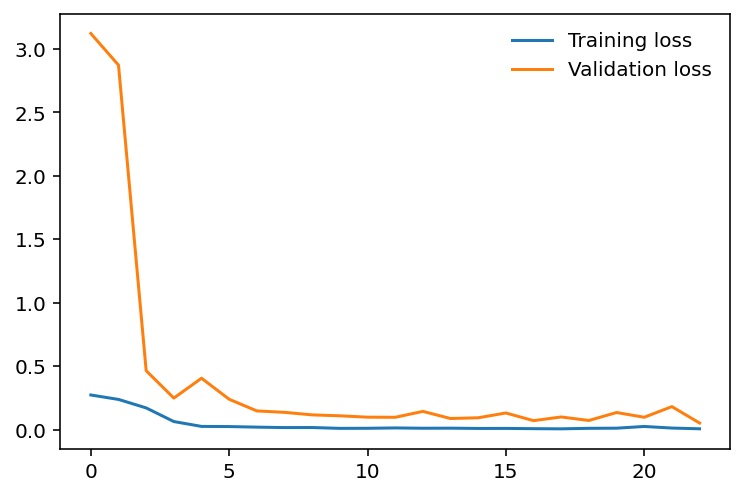

In [17]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

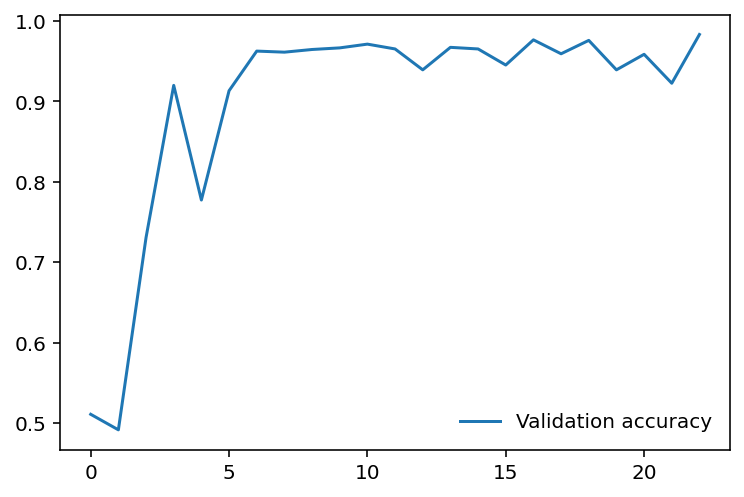

In [18]:
#plt.plot(train_accuracy, label='Training accuracy')
plt.plot(test_accuracies, label='Validation accuracy')
plt.legend(frameon=False)
plt.show()

Those plots show that we reach very high levels of accuracy with our model (up to 98% on the validation set).

# Results and predictions

We saved our model to the file 'road_field.pth' and we can now use it to classify random images from our dataset :

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=torch.load('road_field.pth')
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [20]:
test_transforms = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])
classes = ['field', 'road']

def predict_image(image):
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index

def get_random_images(num):
    data = datasets.ImageFolder(data_dir, transform=test_transforms)
    classes = data.classes
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, 
                   sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = dataiter.next()
    return images, labels

Run this cell to see the predictions of the network on 5 randomly picked images from our dataset :

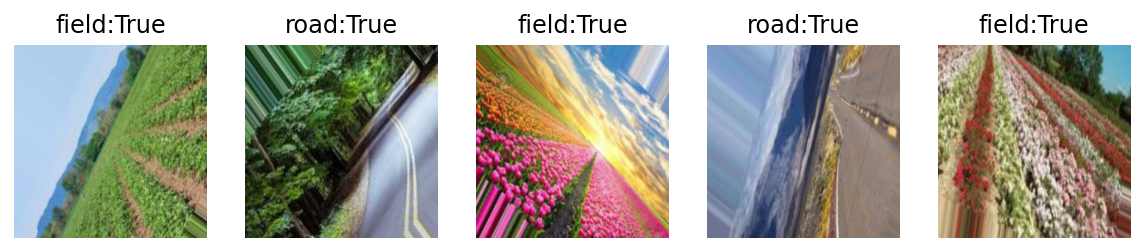

In [21]:
to_pil = transforms.ToPILImage()
images, labels = get_random_images(5)
fig=plt.figure(figsize=(10,10))
for ii in range(len(images)):
    image = to_pil(images[ii])
    index = predict_image(image)
    sub = fig.add_subplot(1, len(images), ii+1)
    res = int(labels[ii]) == index
    sub.set_title(str(classes[index]) + ":" + str(res))
    plt.axis('off')
    plt.imshow(image)
plt.show()

# Conclusion and further work

We trained an efficient classifier for fields and roads, however, we can think of many ways to make our model better :

- First our model needs to be tested on new data, issued from real life experiments, to see if it performs as well as with our dataset.

- Then, we could enrich our dataset with new images from the web to make our model stronger (we have 3600 images available but let's not forget that they all come from the same 90 first images, this has not the same value as a real 3600 images dataset containing only different pictures).

- Finally we could eventually retrain our ResNet architecture fully, which would require more time but eventually result in a better model as the feature layers will specialize for our specific task of field/road classification.

Thanks for taking the time to read this notebook !